<img src = "./bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bxi}{\boldsymbol \xi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\bw}{\boldsymbol{w}}$
$\newcommand{\balpha}{\boldsymbol{\alpha}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Project: Decision Trees


## Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.


Data (*Regression_Supervised_Train_reduced.csv*) consist of a list of features plus the resulting $parcelvalue$, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and $transactiondate$ is the date when the property was effectively sold. Properties are defined by $lotid$, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

Note that you don't have to use $totaltaxvalue$, $buildvalue$ or $landvalue$, because they are closely correlated with the final value to predict.

+ Using this data build a predictive model for $parcelvalue$. Should be one belonging to the decision trees family of models (random forest, adaboost, gbm, xgboost, etc.).
+ Try a first quick implementation, then try to optimize hyperparameters
+ If you have computational problems, try in-class a first version with half of the observations. Remember to paralellize when possible (*n_jobs* parameter).
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the MSE estimate on the test data once released.
+ Bonus: Try an approach to fill NA without removing features or observations, and check improvements.
+ Extra bonus: Try to do a final model that as an ensemble of different decision trees models (e.g. random forest, xgboost, GBM ...), and even including models from another families (SVM, kNN).


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Removing features that have more than 40% of missing data
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features
4. *Build* your model and test it on the same input data.
5. Assess expected accuracy using *cross-validation*
6. Try to assess variable *importance*
7. Prepare the code to *run* on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

You may want to iterate to refine some of these steps once you get performance results in step 5.

**Warning**: Please, to proceed to step 7, first *dump* your model to a file, and load it again from there. Then, remember to share with me not only the notebook, but also the dump file. Here you have an example using package *pickle*.

```python
    # generate model
    my_model= SVC(C=100, probability=True, gamma='scale')
    my_model.fit(xtrain,ytrain)
    
    # save model
    filename = 'stacking_model.sav'
    pickle.dump(my_model, open(filename, 'wb'))

    # load the model from disk and use it
    loaded_model = pickle.load(open(filename, 'rb'))
    loaded_model.predict_proba(xtest)

```

In [1]:
import sys
!{sys.executable} -m pip install category_encoders mlens xgboost

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from math import floor, ceil
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn import preprocessing
from matplotlib.pyplot import figure
from sklearn.metrics import make_scorer
from scipy.stats import skew
import math
import random
from category_encoders.binary import BinaryEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# Some base models
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import ParameterGrid
from sklearn import preprocessing

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner

import pickle

SEED=12345
random.seed(1234)

[MLENS] backend: threading


In [3]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          table=True,
                          display_all_params=True):

    '''Display grid search results
    modified from https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search
    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    table              boolean: should a table be produced?
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_


    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    scores_df = scores_df[scores_df.columns.drop(list(scores_df.filter(regex='time')))] #drop time parameters

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    if table:
        display(scores_df \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

# Overall Approach

Decision Trees: Random Forest, Gradient Boosting, XG Boost?

Ensembles using meta-learner

## Step 1: Read data, report missing data

In [4]:
dataset = pd.read_csv("./Data/Regression_Supervised_Train_reduced.csv")
dataset.head

<bound method NDFrame.head of           lotid  logerror transactiondate  aircond  style  basement  numbath  \
0      17214744       NaN             NaN      NaN    NaN       NaN      2.0   
1      12018724       NaN             NaN      1.0    NaN       NaN      2.0   
2      11306699       NaN             NaN      1.0    NaN       NaN      3.0   
3      11047729       NaN             NaN      1.0    NaN       NaN      2.0   
4      17174848       NaN             NaN      NaN    NaN       NaN      3.0   
...         ...       ...             ...      ...    ...       ...      ...   
24750  11633053       NaN             NaN      1.0    NaN       NaN      3.0   
24751  10751511       NaN             NaN      1.0    NaN       NaN      2.0   
24752  10719915       NaN             NaN      NaN    NaN       NaN      2.0   
24753  11639212       NaN             NaN      1.0    NaN       NaN      5.0   
24754  17273307       NaN             NaN      NaN    NaN       NaN      2.0   

       nu

Text(0, 0.5, 'Pctg missing data')

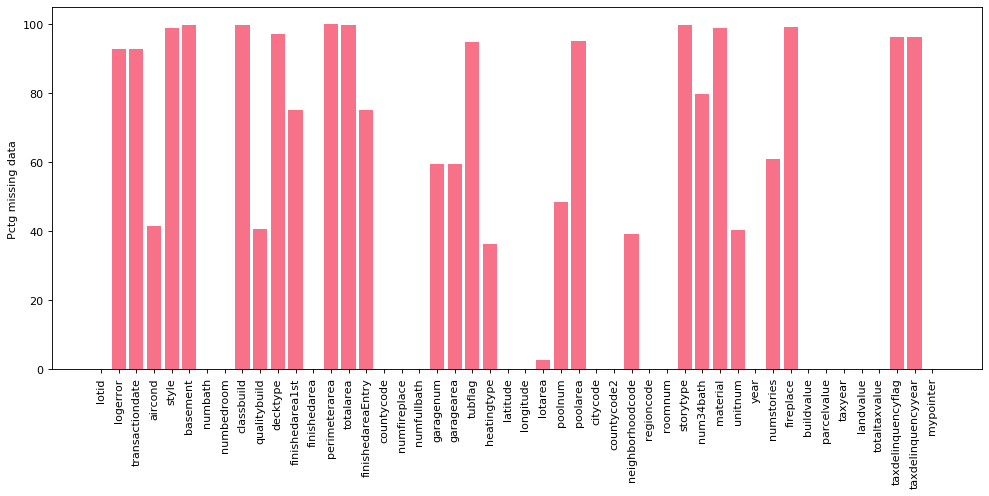

In [5]:
#Report missing data

figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
Nulls= dataset.isnull().sum()
plt.xticks(rotation='vertical')
plt.bar(Nulls.index, 100*Nulls.values/len(dataset.index))
plt.ylabel('Pctg missing data')

## Step 2: Remove features with missing data, and then impute where possible

I will remove the features with too much missing data (more than 40%), since I would not trust an imputation on these features. Then, I will use an Iterative Imputer to fill in the columns with less than 40% missing data. 

In [6]:
#Drop columns required by instructions
dataset2 = dataset.drop(['totaltaxvalue','buildvalue','landvalue'], axis=1)

#Drop columns that are not useful
dataset3 = dataset2.drop(['lotid','mypointer','countycode2', 'neighborhoodcode','regioncode'], axis=1)

#Drop columns with too much missing data
dataset4 = dataset3.dropna(axis=1, thresh=round(dataset.shape[0]*0.6))

Nulls= dataset4.isnull().sum()
any_missing = 100*Nulls.values/len(dataset4.index)>0
col_indices = [any_missing[i]*i for i in range(len(dataset4.columns))]

col_impute = []
for i in col_indices:
    if i != 0:
        col_impute.append(dataset4.columns[i])

In [7]:
col_impute

['finishedarea', 'numfullbath', 'heatingtype', 'lotarea', 'citycode', 'year']

I will split these features into continuous and categorical variables in order to use the appropriate imputers.

In [8]:
col_impute_reg = ['finishedarea','lotarea','year']
col_impute_class = ['numfullbath', 'heatingtype','citycode']

In [9]:
my_estimator1 = KNeighborsRegressor(n_neighbors=2)

dataset5 = dataset4.copy()
dataset5 = dataset5.drop('parcelvalue', axis=1)
dataset5 = dataset5.drop(col_impute_class, axis=1)

columns_without_classimp = dataset5.columns

# Imputation
cont_imputer=IterativeImputer(random_state=0, estimator=my_estimator1, max_iter=30,add_indicator=True)
cont_imputer.fit(dataset5)
dataset5=cont_imputer.transform(dataset5)

dataset6 = pd.concat([pd.DataFrame(dataset5[:,:11]), dataset4[col_impute_class]], axis=1)

In [10]:
my_estimator2 = KNeighborsClassifier(n_neighbors=2)

# Imputation
cat_imputer=IterativeImputer(random_state=0, estimator=my_estimator2, max_iter=30,add_indicator=True)
cat_imputer.fit(dataset6)
dataset6=cat_imputer.transform(dataset6)

dataset7=pd.DataFrame(dataset6[:,:14])

In [11]:
col_titles = list(columns_without_classimp) + col_impute_class
dataset7.columns = col_titles

In [12]:
#Check for any missing data
dataset7.isnull().sum()

numbath         0
numbedroom      0
finishedarea    0
countycode      0
numfireplace    0
latitude        0
longitude       0
lotarea         0
roomnum         0
year            0
taxyear         0
numfullbath     0
heatingtype     0
citycode        0
dtype: int64

## Step 3: Transforming features

I will use two types of encoding for the categorical features. For countycode, since there are only 3 categories, I will use one-hot encoding. For heatingtype and citycode, there are many categories, so I will use a Binary Encoder. I will also engineer finishedareasq as the square of the finishedarea variable and take the log of parcelvalue as the y variable. 

In [13]:
X_pretrain = dataset7
y_train = dataset4["parcelvalue"]

dummy_cols = ['citycode','countycode','heatingtype']

for col in dummy_cols:
    X_pretrain[col] = X_pretrain[col].astype(str)
    
city_encoder = BinaryEncoder()
X_pretrain = pd.concat([X_pretrain, city_encoder.fit_transform(X_pretrain['citycode'])], axis=1)

heating_encoder = BinaryEncoder()
X_pretrain = pd.concat([X_pretrain, heating_encoder.fit_transform(X_pretrain['heatingtype'])], axis=1)

X_pretrain = pd.concat([X_pretrain, pd.get_dummies(X_pretrain['countycode'], drop_first=True, prefix='county')], axis=1)

#Add terms that are more relevant
X_pretrain['finishedareasq'] = X_pretrain['finishedarea']**2

X_pretrain = X_pretrain.drop(dummy_cols, axis=1)

features = X_pretrain.columns
#Apply log to y to reduce skewness
y_train = pd.Series([math.log(i) for i in y_train])

## Step 4: Build your model and get predictions

First, I will train a Gradient Boosting Regressor and get the predictions from the test set to assess its accuracy. Then, I will train a Random Forest Regressor, KNN Regressor and SVR separately and get the optimal parameters for each model. Finally, I will use these models to build an ensemble using an Extra Trees Regressor. 

In [14]:
#I will do a train-test split in order to assess the expected accuracy of the ensemble that I will build later
X_pretrain, X_pretest, y_train, y_test = train_test_split(X_pretrain, y_train, test_size=0.1, random_state=SEED)

In [15]:
#Scale data
scaler = preprocessing.StandardScaler().fit(X_pretrain)
X_train = pd.DataFrame(scaler.transform(X_pretrain))
X_test = pd.DataFrame(scaler.transform(X_pretest))

In [194]:
MyTree = GradientBoostingRegressor()
grid_values = {'n_estimators':[100, 125, 150],
               'learning_rate':[0.1, 0.3, 0.5],
               'loss':['ls','lad','huber']}
grid_tree_acc = GridSearchCV(MyTree, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5, n_jobs = -1)
grid_tree_acc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

Best n_estimators parameter : 150
Best learning_rate parameter : 0.3
Best loss function : ls
best parameters: {'learning_rate': 0.3, 'loss': 'ls', 'n_estimators': 150}
best score:      -0.28157 (+/-0.00766)


,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.3,ls,150,"{'learning_rate': 0.3, 'loss': 'ls', 'n_estima...",-0.276518,-0.289775,-0.272334,-0.291549,-0.277658,-0.281567,0.007656,1
10,0.3,ls,125,"{'learning_rate': 0.3, 'loss': 'ls', 'n_estima...",-0.275851,-0.289665,-0.271801,-0.293037,-0.277619,-0.281595,0.008256,2
9,0.3,ls,100,"{'learning_rate': 0.3, 'loss': 'ls', 'n_estima...",-0.276944,-0.291160,-0.273095,-0.292329,-0.278297,-0.282365,0.007855,3
16,0.3,huber,125,"{'learning_rate': 0.3, 'loss': 'huber', 'n_est...",-0.277302,-0.296910,-0.275172,-0.297129,-0.278008,-0.284904,0.009936,4
17,0.3,huber,150,"{'learning_rate': 0.3, 'loss': 'huber', 'n_est...",-0.278677,-0.296662,-0.275867,-0.296564,-0.278008,-0.285156,0.009401,5
15,0.3,huber,100,"{'learning_rate': 0.3, 'loss': 'huber', 'n_est...",-0.277280,-0.297080,-0.276320,-0.297184,-0.278737,-0.285321,0.009675,6
2,0.1,ls,150,"{'learning_rate': 0.1, 'loss': 'ls', 'n_estima...",-0.277690,-0.295131,-0.277121,-0.296410,-0.280751,-0.285421,0.008550,7
1,0.1,ls,125,"{'learning_rate': 0.1, 'loss': 'ls', 'n_estima...",-0.278321,-0.296787,-0.278013,-0.297555,-0.282030,-0.286541,0.008797,8
24,0.5,huber,100,"{'learning_rate': 0.5, 'loss': 'huber', 'n_est...",-0.277948,-0.296055,-0.279686,-0.295468,-0.284516,-0.286735,0.007681,9
8,0.1,huber,150,"{'learning_rate': 0.1, 'loss': 'huber', 'n_est...",-0.277138,-0.299345,-0.277192,-0.300110,-0.281515,-0.287060,0.010467,10


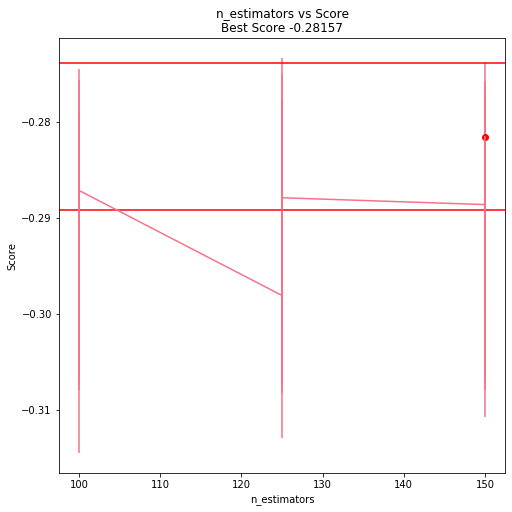

In [195]:
#Best Cost parameter
print('Best n_estimators parameter : '+ str(grid_tree_acc.best_estimator_.n_estimators))
print('Best learning_rate parameter : '+ str(grid_tree_acc.best_estimator_.learning_rate))
print('Best loss function : '+ str(grid_tree_acc.best_estimator_.loss))

# Report best Number of Neighbors
GridSearch_table_plot(grid_tree_acc, "n_estimators", negative=False, display_all_params=False)


In [196]:
gb = GradientBoostingRegressor(n_estimators=grid_tree_acc.best_estimator_.n_estimators,
                                   learning_rate=grid_tree_acc.best_estimator_.learning_rate,
                                   loss=grid_tree_acc.best_estimator_.loss)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

#Convert predictions and y values to original scale
gb_pred_orig = [math.exp(i) for i in gb_pred]
gb_test_orig = [math.exp(i) for i in y_test]

#Calculate mean squared error
score_gb = mean_squared_error(gb_test_orig, gb_pred_orig)
r2_gb = r2_score(gb_test_orig, gb_pred_orig)
print("\nGradient Boosting Regressor MSE: %.3f" % score_gb)
print("\nGradient Boosting Regressor R-squared: %.3f" % r2_gb)


Gradient Boosting Regressor MSE: 155525148327.707

Gradient Boosting Regressor R-squared: 0.554


### Building an Ensemble 

I will move on to selecting the best parameters for other algorithms. After that, I will build an ensemble using all the tuned variables.

Best n_estimators parameter : 125
Best max_depth parameter : 10
best parameters: {'max_depth': 10, 'n_estimators': 125}
best score:      -0.28775 (+/-0.00891)


,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,10,125,"{'max_depth': 10, 'n_estimators': 125}",-0.279014,-0.298070,-0.282111,-0.299121,-0.280447,-0.287753,0.008913,1
3,10,75,"{'max_depth': 10, 'n_estimators': 75}",-0.277582,-0.298196,-0.282687,-0.299624,-0.281010,-0.287820,0.009215,2
4,10,100,"{'max_depth': 10, 'n_estimators': 100}",-0.278735,-0.298090,-0.283613,-0.300108,-0.280143,-0.288138,0.009112,3
8,20,125,"{'max_depth': 20, 'n_estimators': 125}",-0.285200,-0.298030,-0.291234,-0.303597,-0.285885,-0.292790,0.007099,4
7,20,100,"{'max_depth': 20, 'n_estimators': 100}",-0.287820,-0.298409,-0.291753,-0.304701,-0.286664,-0.293870,0.006796,5
6,20,75,"{'max_depth': 20, 'n_estimators': 75}",-0.288950,-0.299809,-0.293478,-0.303690,-0.287190,-0.294624,0.006291,6
2,5,125,"{'max_depth': 5, 'n_estimators': 125}",-0.306287,-0.338048,-0.310386,-0.333124,-0.315754,-0.320720,0.012601,7
1,5,100,"{'max_depth': 5, 'n_estimators': 100}",-0.306493,-0.337770,-0.310481,-0.333773,-0.315820,-0.320868,0.012588,8
0,5,75,"{'max_depth': 5, 'n_estimators': 75}",-0.307328,-0.338227,-0.310943,-0.334386,-0.315553,-0.321288,0.012596,9


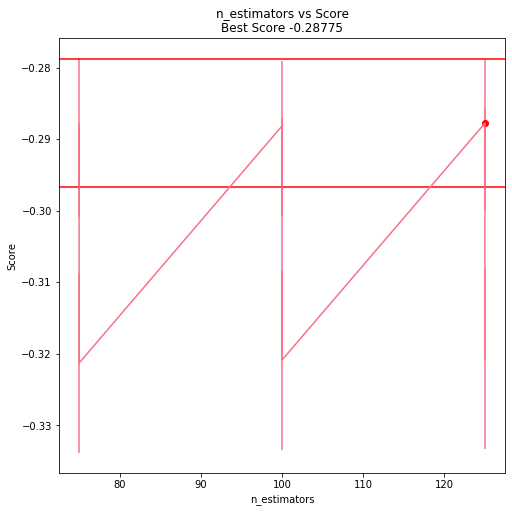

In [197]:
MyForest = RandomForestRegressor()
grid_values = {'n_estimators':[75, 100, 125],
               'max_depth':[5, 10, 20]}
grid_forest_acc = GridSearchCV(MyForest, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5, n_jobs = -2)
grid_forest_acc.fit(X_train, y_train)

#Best Cost parameter
print('Best n_estimators parameter : '+ str(grid_forest_acc.best_estimator_.n_estimators))
print('Best max_depth parameter : '+ str(grid_forest_acc.best_estimator_.max_depth))

# Report best Number of Neighbors
GridSearch_table_plot(grid_forest_acc, "n_estimators", negative=False, display_all_params=False)

Best kernel : rbf
Best Cost parameter : 1
best parameters: {'C': 1, 'epsilon': 0.5, 'gamma': 0.05, 'kernel': 'rbf'}
best score:      -0.30056 (+/-0.00897)


,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,1,0.5,0.05,rbf,"{'C': 1, 'epsilon': 0.5, 'gamma': 0.05, 'kerne...",-0.291294,-0.313538,-0.296051,-0.308924,-0.292975,-0.300557,0.008968,1
18,1,0.1,0.05,rbf,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.05, 'kerne...",-0.298390,-0.320736,-0.299854,-0.317132,-0.299502,-0.307123,0.009723,2
42,10,0.5,0.05,rbf,"{'C': 10, 'epsilon': 0.5, 'gamma': 0.05, 'kern...",-0.297187,-0.318898,-0.305580,-0.316058,-0.300293,-0.307603,0.008545,3
26,1,0.5,0.1,rbf,"{'C': 1, 'epsilon': 0.5, 'gamma': 0.1, 'kernel...",-0.298188,-0.323093,-0.307759,-0.316550,-0.297679,-0.308654,0.010016,4
20,1,0.1,0.1,rbf,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.1, 'kernel...",-0.306128,-0.329003,-0.308323,-0.322291,-0.302659,-0.313681,0.010160,5
36,10,0.1,0.05,rbf,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.05, 'kern...",-0.310629,-0.328388,-0.310178,-0.323155,-0.309112,-0.316293,0.007930,6
6,0.1,0.5,0.05,rbf,"{'C': 0.1, 'epsilon': 0.5, 'gamma': 0.05, 'ker...",-0.306528,-0.333584,-0.313957,-0.326468,-0.309318,-0.317971,0.010372,7
0,0.1,0.1,0.05,rbf,"{'C': 0.1, 'epsilon': 0.1, 'gamma': 0.05, 'ker...",-0.310004,-0.338822,-0.313434,-0.330940,-0.311912,-0.321023,0.011638,8
44,10,0.5,0.1,rbf,"{'C': 10, 'epsilon': 0.5, 'gamma': 0.1, 'kerne...",-0.316250,-0.335779,-0.325774,-0.331266,-0.312455,-0.324305,0.008804,9
28,1,0.5,0.2,rbf,"{'C': 1, 'epsilon': 0.5, 'gamma': 0.2, 'kernel...",-0.319031,-0.347667,-0.334941,-0.334799,-0.315583,-0.330405,0.011721,10


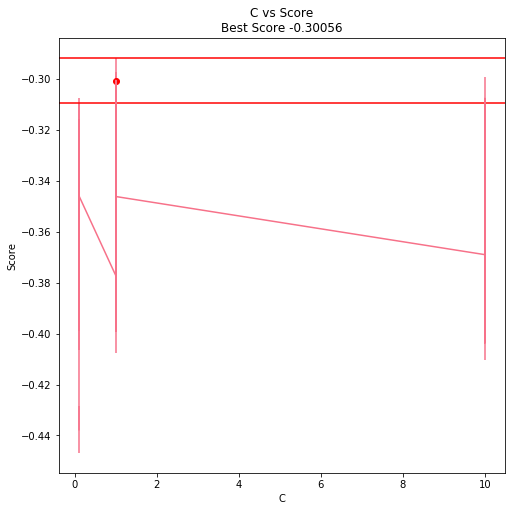

In [198]:
#Grid Search CV for SVR

MySvr = SVR()
grid_values = {'kernel':['rbf','linear'],
               'C':[0.1,1,10], 
               'gamma':[0.05, 0.1, 0.2],
               'epsilon':[0.1,0.5,1]}
grid_svr_acc = GridSearchCV(MySvr, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5)
grid_svr_acc.fit(X_train, y_train)

#Best parameters
print('Best kernel : '+ str(grid_svr_acc.best_estimator_.kernel))
print('Best Cost parameter : '+ str(grid_svr_acc.best_estimator_.C))

# Report best Number of Neighbors
GridSearch_table_plot(grid_svr_acc, "C", negative=False, display_all_params=False)

Best n_neighbors : 20
Best weights parameter : uniform
best parameters: {'n_neighbors': 20, 'weights': 'uniform'}
best score:      -0.32394 (+/-0.00930)


,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",-0.312095,-0.333512,-0.321438,-0.335907,-0.316768,-0.323944,0.009304,1
5,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",-0.317205,-0.332510,-0.324566,-0.341664,-0.316810,-0.326551,0.009488,2
2,10,uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",-0.322288,-0.337479,-0.326858,-0.344848,-0.320498,-0.330394,0.009330,3
3,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",-0.331471,-0.341861,-0.335462,-0.355406,-0.325468,-0.337934,0.010237,4
0,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",-0.344392,-0.354616,-0.343707,-0.370250,-0.334857,-0.349565,0.012089,5
1,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",-0.358097,-0.364042,-0.358281,-0.382886,-0.346624,-0.361987,0.011881,6


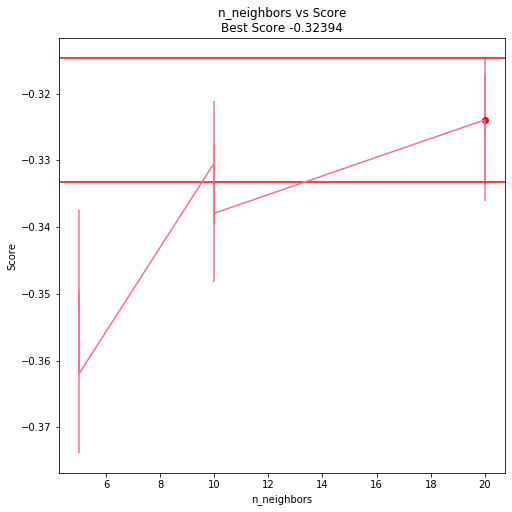

In [199]:
#Grid Search CV for KNN

MyKNN = KNeighborsRegressor()
grid_values = {'n_neighbors':[5,10,20],
               'weights':['uniform','distance']}
grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5,n_jobs=-2)
grid_knn_acc.fit(X_train, y_train)

#Best parameters
print('Best n_neighbors : '+ str(grid_knn_acc.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc.best_estimator_.weights))

# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [200]:
#Building the meta-learner

def get_models():
    #Generate a library of simple learners
    svr = SVR(kernel=grid_svr_acc.best_estimator_.kernel,
              C=grid_svr_acc.best_estimator_.C,
              gamma=grid_svr_acc.best_estimator_.gamma,
              epsilon=grid_svr_acc.best_estimator_.epsilon)
    knn = KNeighborsRegressor(n_neighbors=grid_knn_acc.best_estimator_.n_neighbors,
                              weights=grid_knn_acc.best_estimator_.weights)
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=grid_forest_acc.best_estimator_.n_estimators, 
                               max_depth=grid_forest_acc.best_estimator_.max_depth)
    gb = GradientBoostingRegressor(n_estimators=grid_tree_acc.best_estimator_.n_estimators,
                                   learning_rate=grid_tree_acc.best_estimator_.learning_rate,
                                   loss=grid_tree_acc.best_estimator_.loss)

    models = {'svm': svr,
              'knn': knn,
              'random forest': rf,
              'gradient boosting': gb,
              'linear': lr,
              }

    return models

models = get_models()

meta_learner = ExtraTreesRegressor(
    n_estimators=50,
    criterion='mse',
    bootstrap=True,
    max_features=0.7,
    random_state=SEED)

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    random_state=SEED,
    verbose=2
)

# Add the base learners and the meta learner
sl.add(list(models.values()))
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train, y_train)

#Get predictions for the test set
p_sl = sl.predict(X_test)


Fitting 2 layers
Processing layer-1             

JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/vivek/anaconda3/lib/python3.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/runpy.py in _run_code(code=<code object <module> at 0x102e0cdb0, file "/Use...3.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/vivek/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/vivek.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x102e0cdb0, file "/Use...3.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/vivek/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/vivek.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    500         if self.poller is not None:
    501             self.poller.start()
    502         self.kernel.start()
    503         self.io_loop = ioloop.IOLoop.current()
    504         try:
--> 505             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    506         except KeyboardInterrupt:
    507             pass
    508 
    509 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    523         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    524                                finalizer=self._asyncgen_finalizer_hook)
    525         try:
    526             events._set_running_loop(self)
    527             while True:
--> 528                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    529                 if self._stopping:
    530                     break
    531         finally:
    532             self._stopping = False

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1759                         logger.warning('Executing %s took %.3f seconds',
   1760                                        _format_handle(handle), dt)
   1761                 finally:
   1762                     self._current_handle = None
   1763             else:
-> 1764                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...ea8>, ...]))>))>>
   1765         handle = None  # Needed to break cycles when an exception occurs.
   1766 
   1767     def _set_coroutine_origin_tracking(self, enabled):
   1768         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/asyncio/events.py in _run(self=<Handle IOLoop._run_callback(functools.par...ea8>, ...]))>))>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_w...abadf0>, <zmq.sugar.fr... 0x1a18abaea8>, ...]))>),)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_w...abadf0>, <zmq.sugar.fr... 0x1a18abaea8>, ...]))>))
    753         """Runs a callback with error handling.
    754 
    755         For use in subclasses.
    756         """
    757         try:
--> 758             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_w...abadf0>, <zmq.sugar.fr... 0x1a18abaea8>, ...]))>)
    759             if ret is not None:
    760                 from tornado import gen
    761                 # Functions that return Futures typically swallow all
    762                 # exceptions and store them in the Future.  If a Future

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<Future finished result=(10, 239, <bound method....8abadf0>, <zmq.sugar.fr... 0x1a18abaea8>, ...]))>,), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<Future finished result=(10, 239, <bound method....8abadf0>, <zmq.sugar.fr... 0x1a18abaea8>, ...]))>,)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/gen.py in inner(f=None)
   1228             return False
   1229         elif not self.future.done():
   1230             def inner(f):
   1231                 # Break a reference cycle to speed GC.
   1232                 f = None  # noqa
-> 1233                 self.run()
   1234             self.io_loop.add_future(
   1235                 self.future, inner)
   1236             return False
   1237         return True

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/gen.py in run(self=<tornado.gen.Runner object>)
   1142                         finally:
   1143                             # Break up a reference to itself
   1144                             # for faster GC on CPython.
   1145                             exc_info = None
   1146                     else:
-> 1147                         yielded = self.gen.send(value)
        yielded = undefined
        self.gen.send = <built-in method send of generator object>
        value = (10, 239, <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>, (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]))
   1148 
   1149                     if stack_context._state.contexts is not orig_stack_contexts:
   1150                         self.gen.throw(
   1151                             stack_context.StackContextInconsistentError(

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in process_one(self=<ipykernel.ipkernel.IPythonKernel object>, wait=True)
    352         else:
    353             try:
    354                 priority, t, dispatch, args = self.msg_queue.get_nowait()
    355             except QueueEmpty:
    356                 return None
--> 357         yield gen.maybe_future(dispatch(*args))
        dispatch = <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>
        args = (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    358 
    359     @gen.coroutine
    360     def dispatch_queue(self):
    361         """Coroutine to preserve order of message handling

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object Kernel.dispatch_shell>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 12, 18, 7, 57, 54, 659098, tzinfo=tzutc()), 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'session': '1f4babc21e12469599e172aaba0a4251', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'parent_header': {}})
    262             try:
    263                 self.pre_handler_hook()
    264             except Exception:
    265                 self.log.debug("Unable to signal in pre_handler_hook:", exc_info=True)
    266             try:
--> 267                 yield gen.maybe_future(handler(stream, idents, msg))
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'1f4babc21e12469599e172aaba0a4251']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 12, 18, 7, 57, 54, 659098, tzinfo=tzutc()), 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'session': '1f4babc21e12469599e172aaba0a4251', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'parent_header': {}}
    268             except Exception:
    269                 self.log.error("Exception in message handler:", exc_info=True)
    270             finally:
    271                 try:

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [b'1f4babc21e12469599e172aaba0a4251'], {'buffers': [], 'content': {'allow_stdin': True, 'code': '#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 12, 18, 7, 57, 54, 659098, tzinfo=tzutc()), 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'session': '1f4babc21e12469599e172aaba0a4251', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'parent_header': {}}), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object Kernel.execute_request>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'1f4babc21e12469599e172aaba0a4251'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 12, 18, 7, 57, 54, 659098, tzinfo=tzutc()), 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'session': '1f4babc21e12469599e172aaba0a4251', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'c5b53f783eeb43858958851507e7b522', 'msg_type': 'execute_request', 'parent_header': {}})
    529             self._publish_execute_input(code, parent, self.execution_count)
    530 
    531         reply_content = yield gen.maybe_future(
    532             self.do_execute(
    533                 code, silent, store_history,
--> 534                 user_expressions, allow_stdin,
        user_expressions = {}
        allow_stdin = True
    535             )
    536         )
    537 
    538         # Flush output before sending the reply.

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/tornado/gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, '#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', False, True, {}, True), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object IPythonKernel.do_execute>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    289                     res = yield coro_future
    290             else:
    291                 # runner isn't already running,
    292                 # make synchronous call,
    293                 # letting shell dispatch to loop runners
--> 294                 res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        code = '#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)'
        store_history = True
        silent = False
    295         finally:
    296             self._restore_input()
    297 
    298         if res.error_before_exec is not None:

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)',), **kwargs={'silent': False, 'store_history': True})
    531             )
    532         self.payload_manager.write_payload(payload)
    533 
    534     def run_cell(self, *args, **kwargs):
    535         self._last_traceback = None
--> 536         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)',)
        kwargs = {'silent': False, 'store_history': True}
    537 
    538     def _showtraceback(self, etype, evalue, stb):
    539         # try to preserve ordering of tracebacks and print statements
    540         sys.stdout.flush()

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', store_history=True, silent=False, shell_futures=True)
   2814         result : :class:`ExecutionResult`
   2815         """
   2816         result = None
   2817         try:
   2818             result = self._run_cell(
-> 2819                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)'
        store_history = True
        silent = False
        shell_futures = True
   2820         finally:
   2821             self.events.trigger('post_execute')
   2822             if not silent:
   2823                 self.events.trigger('post_run_cell', result)

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', store_history=True, silent=False, shell_futures=True)
   2840             runner = self.loop_runner
   2841         else:
   2842             runner = _pseudo_sync_runner
   2843 
   2844         try:
-> 2845             return runner(coro)
        runner = <function _pseudo_sync_runner>
        coro = <generator object InteractiveShell.run_cell_async>
   2846         except BaseException as e:
   2847             info = ExecutionInfo(raw_cell, store_history, silent, shell_futures)
   2848             result = ExecutionResult(info)
   2849             result.error_in_exec = e

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py in _pseudo_sync_runner(coro=<generator object InteractiveShell.run_cell_async>)
     62 
     63     Credit to Nathaniel Smith
     64 
     65     """
     66     try:
---> 67         coro.send(None)
        coro.send = <built-in method send of generator object>
     68     except StopIteration as exc:
     69         return exc.value
     70     else:
     71         # TODO: do not raise but return an execution result with the right info.

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell_async(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='#Building the meta-learner\n\ndef get_models():\n  ...ctions for the test set\np_sl = sl.predict(X_test)', store_history=True, silent=False, shell_futures=True)
   3015                 interactivity = "none" if silent else self.ast_node_interactivity
   3016                 if _run_async:
   3017                     interactivity = 'async'
   3018 
   3019                 has_raised = yield from self.run_ast_nodes(code_ast.body, cell_name,
-> 3020                        interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   3021 
   3022                 self.last_execution_succeeded = not has_raised
   3023                 self.last_execution_result = result
   3024 

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>], cell_name='<ipython-input-200-04382593544b>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1a20dd0c88, execution...rue silent=False shell_futures=True> result=None>)
   3180                     return True
   3181             else:
   3182                 for i, node in enumerate(to_run_exec):
   3183                     mod = ast.Module([node])
   3184                     code = compiler(mod, cell_name, "exec")
-> 3185                     if (yield from self.run_code(code, result)):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a1b222390, file "<ipython-input-200-04382593544b>", line 48>
        result = <ExecutionResult object at 1a20dd0c88, execution...rue silent=False shell_futures=True> result=None>
   3186                         return True
   3187 
   3188                 for i, node in enumerate(to_run_interactive):
   3189                     mod = ast.Interactive([node])

...........................................................................
/Users/vivek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a1b222390, file "<ipython-input-200-04382593544b>", line 48>, result=<ExecutionResult object at 1a20dd0c88, execution...rue silent=False shell_futures=True> result=None>, async_=False)
   3262                 if async_:
   3263                     last_expr = (yield from self._async_exec(code_obj, self.user_ns))
   3264                     code = compile('last_expr', 'fake', "single")
   3265                     exec(code, {'last_expr': last_expr})
   3266                 else:
-> 3267                     exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a1b222390, file "<ipython-input-200-04382593544b>", line 48>
        self.user_global_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'BaggingRegressor': <class 'sklearn.ensemble.bagging.BaggingRegressor'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'BinaryEncoder': <class 'category_encoders.binary.BinaryEncoder'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, ...}
        self.user_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'BaggingRegressor': <class 'sklearn.ensemble.bagging.BaggingRegressor'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'BinaryEncoder': <class 'category_encoders.binary.BinaryEncoder'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, ...}
   3268             finally:
   3269                 # Reset our crash handler in place
   3270                 sys.excepthook = old_excepthook
   3271         except SystemExit as e:

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/<ipython-input-200-04382593544b> in <module>()
     43 # Add the base learners and the meta learner
     44 sl.add(list(models.values()))
     45 sl.add_meta(meta_learner)
     46 
     47 # Train the ensemble
---> 48 sl.fit(X_train, y_train)
     49 
     50 #Get predictions for the test set
     51 p_sl = sl.predict(X_test)

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/ensemble/base.py in fit(self=SuperLearner(array_check=None, backend=None, fol...20, scorer=None, shuffle=False,
       verbose=2), X=             0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns], y=[12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...], **kwargs={})
    509             return self
    510 
    511         if self.model_selection:
    512             self._id_train.fit(X)
    513 
--> 514         out = self._backend.fit(X, y, **kwargs)
        out = undefined
        self._backend.fit = <bound method Sequential.fit of Sequential(backe...nsformers=[])],
   verbose=1)],
      verbose=2)>
        X =              0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns]
        y = [12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...]
        kwargs = {}
    515         if out is not self._backend:
    516             # fit_transform
    517             return out
    518         else:

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/ensemble/base.py in fit(self=Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=1)],
      verbose=2), X=             0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns], y=[12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...], **kwargs={})
    153 
    154         f, t0 = print_job(self, "Fitting")
    155 
    156         with ParallelProcessing(self.backend, self.n_jobs,
    157                                 max(self.verbose - 4, 0)) as manager:
--> 158             out = manager.stack(self, 'fit', X, y, **kwargs)
        out = undefined
        manager.stack = <bound method ParallelProcessing.stack of <mlens.parallel.backend.ParallelProcessing object>>
        self = Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=1)],
      verbose=2)
        X =              0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns]
        y = [12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...]
        kwargs = {}
    159 
    160         if self.verbose:
    161             print_time(t0, "{:<35}".format("Fit complete"), file=f)
    162 

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/backend.py in stack(self=<mlens.parallel.backend.ParallelProcessing object>, caller=Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=1)],
      verbose=2), job='fit', X=             0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns], y=[12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...], path=None, return_preds=False, warm_start=False, split=True, **kwargs={})
    668             Prediction array(s).
    669         """
    670         out = self.initialize(
    671             job=job, X=X, y=y, path=path, warm_start=warm_start,
    672             return_preds=return_preds, split=split, stack=True)
--> 673         return self.process(caller=caller, out=out, **kwargs)
        self.process = <bound method ParallelProcessing.process of <mlens.parallel.backend.ParallelProcessing object>>
        caller = Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=1)],
      verbose=2)
        out = {}
        kwargs = {}
    674 
    675     def process(self, caller, out, **kwargs):
    676         """Process job.
    677 

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/backend.py in process(self=<mlens.parallel.backend.ParallelProcessing object>, caller=Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=1)],
      verbose=2), out=None, **kwargs={})
    713                       backend=self.backend) as parallel:
    714 
    715             for task in caller:
    716                 self.job.clear()
    717 
--> 718                 self._partial_process(task, parallel, **kwargs)
        self._partial_process = <bound method ParallelProcessing._partial_proces...lens.parallel.backend.ParallelProcessing object>>
        task = Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=1)
        parallel = Parallel(n_jobs=-1)
        kwargs = {}
    719 
    720                 if task.name in return_names:
    721                     out.append(self.get_preds(dtype=_dtype(task)))
    722 

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/backend.py in _partial_process(self=<mlens.parallel.backend.ParallelProcessing object>, task=Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=1), parallel=Parallel(n_jobs=-1), **kwargs={})
    734         task.setup(self.job.predict_in, self.job.targets, self.job.job)
    735 
    736         if not task.__no_output__:
    737             self._gen_prediction_array(task, self.job.job, self.__threading__)
    738 
--> 739         task(self.job.args(**kwargs), parallel=parallel)
        task = Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=1)
        self.job.args = <bound method Job.args of <mlens.parallel.backend.Job object>>
        kwargs = {}
        parallel = Parallel(n_jobs=-1)
    740 
    741         if not task.__no_output__ and getattr(task, 'n_feature_prop', 0):
    742             self._propagate_features(task)
    743 

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/layer.py in __call__(self=Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=1), args={'auxiliary': {'P': None, 'X':              0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns], 'y': [12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...]}, 'dir': [('kneighborsregressor.0.0', <mlens.parallel.learner.IndexedEstimator object>), ('gradientboostingregressor.0.0', <mlens.parallel.learner.IndexedEstimator object>)], 'job': 'fit', 'main': {'P': array([[0., 0., 0., 0., 0.],
       [0., 0., 0.,...0.],
       [0., 0., 0., 0., 0.]], dtype=float32), 'X':              0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns], 'y': [12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...]}}, parallel=Parallel(n_jobs=-1))
    147         if self.verbose >= 2:
    148             safe_print(msg.format('Learners ...'), file=f, end=e2)
    149             t1 = time()
    150 
    151         parallel(delayed(sublearner, not _threading)()
--> 152                  for learner in self.learners
        self.learners = [Learner(attr='predict', backend='threading', dty...=False,
    raise_on_exception=True, scorer=None), Learner(attr='predict', backend='threading', dty...=False,
    raise_on_exception=True, scorer=None), Learner(attr='predict', backend='threading', dty...=False,
    raise_on_exception=True, scorer=None), Learner(attr='predict', backend='threading', dty...=False,
    raise_on_exception=True, scorer=None), Learner(attr='predict', backend='threading', dty...=False, raise_on_exception=True,
    scorer=None)]
    153                  for sublearner in learner(args, 'main'))
    154 
    155         if self.verbose >= 2:
    156             print_time(t1, 'done', file=f)

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object Layer.__call__.<locals>.<genexpr>>)
    788             if pre_dispatch == "all" or n_jobs == 1:
    789                 # The iterable was consumed all at once by the above for loop.
    790                 # No need to wait for async callbacks to trigger to
    791                 # consumption.
    792                 self._iterating = False
--> 793             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    794             # Make sure that we get a last message telling us we are done
    795             elapsed_time = time.time() - self._start_time
    796             self._print('Done %3i out of %3i | elapsed: %s finished',
    797                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Wed Dec 18 08:57:54 2019
PID: 28177                  Python 3.7.1: /Users/vivek/anaconda3/bin/python
...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/externals/joblib/parallel.py in __call__(self=<mlens.externals.joblib.parallel.BatchedCalls object>)
    130     def __init__(self, iterator_slice):
    131         self.items = list(iterator_slice)
    132         self._size = len(self.items)
    133 
    134     def __call__(self):
--> 135         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<mlens.parallel.learner.SubLearner object>, (), {})]
    136 
    137     def __len__(self):
    138         return self._size
    139 

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    130     def __init__(self, iterator_slice):
    131         self.items = list(iterator_slice)
    132         self._size = len(self.items)
    133 
    134     def __call__(self):
--> 135         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <mlens.parallel.learner.SubLearner object>
        args = ()
        kwargs = {}
    136 
    137     def __len__(self):
    138         return self._size
    139 

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/learner.py in __call__(self=<mlens.parallel.learner.SubLearner object>)
    119         else:
    120             self.processing_index = ''
    121 
    122     def __call__(self):
    123         """Launch job"""
--> 124         return getattr(self, self.job)()
        self = <mlens.parallel.learner.SubLearner object>
        self.job = 'fit'
    125 
    126     def fit(self, path=None):
    127         """Fit sub-learner"""
    128         if path is None:

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/learner.py in fit(self=<mlens.parallel.learner.SubLearner object>, path=[])
    128         if path is None:
    129             path = self.path
    130         t0 = time()
    131         transformers = self._load_preprocess(path)
    132 
--> 133         self._fit(transformers)
        self._fit = <bound method SubLearner._fit of <mlens.parallel.learner.SubLearner object>>
        transformers = None
    134 
    135         if self.out_array is not None:
    136             self._predict(transformers, self.scorer is not None)
    137 

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/learner.py in _fit(self=<mlens.parallel.learner.SubLearner object>, transformers=None)
    166         """Predict with sublearner"""
    167         return self.predict(path)
    168 
    169     def _fit(self, transformers):
    170         """Sub-routine to fit sub-learner"""
--> 171         xtemp, ytemp = slice_array(self.in_array, self.targets, self.in_index)
        xtemp = undefined
        ytemp = undefined
        self.in_array =              0         1         2         3    ... -0.575916 -0.322553  

[22279 rows x 28 columns]
        self.targets = [12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...]
        self.in_index = ((4456, 22279),)
    172 
    173         # Transform input (triggers copying)
    174         t0 = time()
    175         if transformers:

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/_base_functions.py in slice_array(x=             0         1         2         3    ... -0.575916 -0.322553  

[17823 rows x 28 columns], y=[12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...], idx=array([ 4456,  4457,  4458, ..., 22276, 22277, 22278]), r=0)
    161                 # Advanced indexing is required. This will trigger a copy
    162                 # of the slice in question to be made
    163                 simple_slice = False
    164                 idx = np.hstack([np.arange(t0 - r, t1 - r) for t0, t1 in idx])
    165                 x = _safe_slice(x, idx)
--> 166                 y = _safe_slice(y, idx)
        y = [12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...]
        idx = array([ 4456,  4457,  4458, ..., 22276, 22277, 22278])
    167             else:
    168                 # The tuple is of the form ((a, b),) and can be made
    169                 # into a simple (a, b) tuple for which basic slicing applies
    170                 # which allows a view to be returned instead of a copy

...........................................................................
/Users/vivek/Desktop/Computational ML/Nov_21/mlens/parallel/_base_functions.py in _safe_slice(array=[12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...], idx=array([ 4456,  4457,  4458, ..., 22276, 22277, 22278]))
    143     """Slice an array safely along the row axis"""
    144     if array is None:
    145         return array
    146     elif hasattr(array, 'iloc'):
    147         return array.iloc[idx]
--> 148     return array[idx]
        array = [12.384218830913648, 12.285304255121808, 12.833293675973952, 13.872602358474493, 12.184925614928718, 11.997811549055289, 13.450227239488942, 13.184665650000932, 13.33397832905412, 13.15273738125931, 12.627210951532104, 12.698510240982886, 12.11915762753423, 13.309672475709322, 12.611554420166117, 13.564792808777844, 12.23272918201745, 12.664253535810243, 12.194556589568926, 11.662172714034753, ...]
        idx = array([ 4456,  4457,  4458, ..., 22276, 22277, 22278])
    149 
    150 
    151 def slice_array(x, y, idx, r=0):
    152     """Build training array index and slice data."""

TypeError: only integer scalar arrays can be converted to a scalar index
___________________________________________________________________________

In [16]:
#Building the meta-learner

def get_models():
    #Generate a library of simple learners
    svr = SVR(kernel='rbf')
    knn = KNeighborsRegressor(n_neighbors=2,
                              weights='distance')
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=30, n_jobs=1)
    gb = GradientBoostingRegressor(n_estimators=30)

    models = {'svm': svr,
              'knn': knn,
              'random forest': rf,
              'gradient boosting': gb,
              'linear': lr,
              }

    return models

models = get_models()

meta_learner = ExtraTreesRegressor(
    n_estimators=50,
    criterion='mse',
    bootstrap=True,
    max_features=0.7,
    random_state=SEED)

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    random_state=SEED,
    verbose=2,
    n_jobs=1
)

# Add the base learners and the meta learner
sl.add(list(models.values()))
sl.add_meta(meta_learner)


SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4578, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=12345, sample_size=20, scorer=None, shuffle=False,
       verbose=2)

In [ ]:
# Train the ensemble
sl.fit(X_train, y_train)

#Get predictions for the test set
p_sl = sl.predict(X_test)


Fitting 2 layers
Processing layer-1             

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Step 5: Assess expected accuracy

In [ ]:
#Convert predictions and y values to original scale
y_pred_orig = [math.exp(i) for i in p_sl[:, 1]]
y_test_orig = [math.exp(i) for i in y_test]

#Calculate mean squared error
scoreStackXtres=mean_squared_error(y_test_orig, y_pred_orig)
r2_StackXtres = r2_score(y_test_orig, y_pred_orig)
print("\nSuper Learner MSE: %.3f" % scoreStackXtres)
print("\nSuper Learner R-squared: %.3f" % r2_StackXtres)

## Step 6: Assess variable importance

In [ ]:
importance = tree.fit(X_train,y_train).feature_importances_
important_features = pd.Series(data=importance/importance.max() ,index=X_train.columns)
important_features.sort_values(ascending=False)

In [ ]:
plt.bar(range(len(important_10)), important_10, tick_label = important_10.keys())
plt.show()

## Step 7: Prepare code to run and check performance of you model using a new input data with same exact format

First, prepare to dump model

In [ ]:
variables = ['numbath', 'numbedroom', 'finishedarea', 'numfireplace', 'numfullbath',
       'latitude', 'longitude', 'lotarea', 'roomnum', 'year', 'taxyear',
       'countycode', 'heatingtype','citycode','parcelvalue']

In [ ]:
#Impute the missing data and scale the variables

def preprocessor (test1, scaler_finishedarea, scaler_lotarea, scaler_year, features):
    
    import pandas as pd
    import numpy as np
    from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
    from sklearn import preprocessing

    #Impute
    
    col_impute_reg = ['finishedarea','lotarea','year']
    col_impute_class = ['numfullbath', 'heatingtype','citycode']

    #finishedarea
    col_impute_knn = col_impute_reg.copy()
    col_impute_knn.remove('finishedarea')

    dataset5 = test1.copy()
    dataset5 = dataset5.drop(columns = col_impute_knn, axis=1)
    dataset5 = dataset5.drop(columns = col_impute_class, axis=1)

    x_trainNN = dataset5[dataset5['finishedarea'].notnull()].drop(columns='finishedarea')
    y_trainNN = dataset5[dataset5['finishedarea'].notnull()]['finishedarea']

    x_train_missing = dataset5[dataset5['finishedarea'].isnull()].drop(columns='finishedarea')
    y_train_missing = dataset5[dataset5['finishedarea'].isnull()]['finishedarea']

    # scale using trained scaler
    x_trainNN = scaler_finishedarea.transform(x_trainNN)
    x_train_missing = scaler_finishedarea.transform(x_train_missing)

    #Predict the missing values using fitted knn
    predicted_train = knn_finishedarea.predict(x_train_missing)

    dataset5.loc[dataset5['finishedarea'].isnull(),'finishedarea'] = predicted_train
    test1['finishedarea'] = dataset5['finishedarea']


    #lotarea
    col_impute_knn = col_impute_reg.copy()
    col_impute_knn.remove('lotarea')

    dataset5 = test1.copy()
    dataset5 = dataset5.drop(columns = col_impute_knn, axis=1)
    dataset5 = dataset5.drop(columns = col_impute_class, axis=1)

    x_trainNN = dataset5[dataset5['lotarea'].notnull()].drop(columns='lotarea')
    y_trainNN = dataset5[dataset5['lotarea'].notnull()]['lotarea']

    x_train_missing = dataset5[dataset5['lotarea'].isnull()].drop(columns='lotarea')
    y_train_missing = dataset5[dataset5['lotarea'].isnull()]['lotarea']

    # scale using trained scaler
    x_trainNN = scaler_lotarea.transform(x_trainNN)
    x_train_missing = scaler_lotarea.transform(x_train_missing)

    #Predict the missing values using fitted knn
    predicted_train = knn_lotarea.predict(x_train_missing)

    dataset5.loc[dataset5['lotarea'].isnull(),'lotarea'] = predicted_train
    test1['lotarea'] = dataset5['lotarea']


    #year
    col_impute_knn = col_impute_reg.copy()
    col_impute_knn.remove('year')

    dataset5 = test1.copy()
    dataset5 = dataset5.drop(columns = col_impute_knn, axis=1)
    dataset5 = dataset5.drop(columns = col_impute_class, axis=1)

    x_trainNN = dataset5[dataset5['year'].notnull()].drop(columns='year')
    y_trainNN = dataset5[dataset5['year'].notnull()]['year']

    x_train_missing = dataset5[dataset5['year'].isnull()].drop(columns='year')
    y_train_missing = dataset5[dataset5['year'].isnull()]['year']

    # scale using trained scaler
    x_trainNN = scaler_year.transform(x_trainNN)
    x_train_missing = scaler_year.transform(x_train_missing)

    #Predict the missing values using fitted knn
    predicted_train = knn_year.predict(x_train_missing)

    dataset5.loc[dataset5['year'].isnull(),'year'] = predicted_train
    test1['year'] = dataset5['year']


    #numfullbath
    col_impute_knn = col_impute_class.copy()
    col_impute_knn.remove('numfullbath')

    dataset5 = test1.copy()
    dataset5 = dataset5.drop(columns = col_impute_knn, axis=1)

    x_trainNN = dataset5[dataset5['numfullbath'].notnull()].drop(columns='numfullbath')
    y_trainNN = dataset5[dataset5['numfullbath'].notnull()]['numfullbath']

    x_train_missing = dataset5[dataset5['numfullbath'].isnull()].drop(columns='numfullbath')
    y_train_missing = dataset5[dataset5['numfullbath'].isnull()]['numfullbath']

    #Predict the missing values
    predicted_train = knn_numfullbath.predict(x_train_missing)

    dataset5.loc[dataset5['numfullbath'].isnull(),'numfullbath'] = predicted_train
    test1['numfullbath'] = dataset5['numfullbath']

    #heatingtype
    col_impute_knn = col_impute_class.copy()
    col_impute_knn.remove('heatingtype')

    dataset5 = test1.copy()
    dataset5 = dataset5.drop(columns = col_impute_knn, axis=1)

    x_trainNN = dataset5[dataset5['heatingtype'].notnull()].drop(columns='heatingtype')
    y_trainNN = dataset5[dataset5['heatingtype'].notnull()]['heatingtype']

    x_train_missing = dataset5[dataset5['heatingtype'].isnull()].drop(columns='heatingtype')
    y_train_missing = dataset5[dataset5['heatingtype'].isnull()]['heatingtype']

    #Predict the missing values
    predicted_train = knn_heatingtype.predict(x_train_missing)

    dataset5.loc[dataset5['heatingtype'].isnull(),'heatingtype'] = predicted_train
    test1['heatingtype'] = dataset5['heatingtype']

    #citycode
    col_impute_knn = col_impute_class.copy()
    col_impute_knn.remove('citycode')

    dataset5 = test1.copy()
    dataset5 = dataset5.drop(columns = col_impute_knn, axis=1)

    x_trainNN = dataset5[dataset5['citycode'].notnull()].drop(columns='citycode')
    y_trainNN = dataset5[dataset5['citycode'].notnull()]['citycode']

    x_train_missing = dataset5[dataset5['citycode'].isnull()].drop(columns='citycode')
    y_train_missing = dataset5[dataset5['citycode'].isnull()]['citycode']

    #Predict the missing values
    predicted_train = knn_citycode.predict(x_train_missing)

    dataset5.loc[dataset5['citycode'].isnull(),'citycode'] = predicted_train
    test1['citycode'] = dataset5['citycode']
    
    #Create dummies and scale data
    X_pretest = test1.drop(["parcelvalue"], axis=1)

    dummy_cols = ['citycode','countycode','heatingtype']

    for col in dummy_cols:
        X_pretest[col] = X_pretest[col].astype(str)

    X_pretest = pd.get_dummies(X_pretest, drop_first=True)

    #Add terms that are more relevant
    X_pretest['finishedareasq'] = X_pretest['finishedarea']**2

    #Select only features that are in the model
    X_test = pd.DataFrame()
    for f in features:
        if f in X_pretest.columns:
            X_test[f] = X_pretest[f]
        else:
            X_test[f] = 0

    return (X_test)

In [ ]:
def y_preprocessor (test1):
    import math
    y_test = test1["parcelvalue"]
    y_test = [math.log(i) for i in y_test]
    return(y_test)

In [ ]:
filename = 'Tree_model.sav'
pickle.dump((tree, preprocessor, y_preprocessor, variables, scaler_finishedarea, scaler_lotarea, scaler_year, features), open(filename, 'wb'))



In [ ]:
# load the model from disk and use it
tree, preprocessor, y_preprocessor, variables, scaler_finishedarea, scaler_lotarea, scaler_year, features = pickle.load(open(filename, 'rb'))

#Load data
test = pd.read_csv("./Data/Regression_Supervised_Test_1_reduced.csv")

#Select same columns as before
test1 = test[variables]

#Preprocess data
X_test = preprocessor(test1, scaler_finishedarea, scaler_lotarea, scaler_year, features)
y_test = y_preprocessor(test1)

#Predictions
y_pred_test = tree.predict(X_test)

#Assess performance
print('R2 Score : ' + str(sklearn.metrics.r2_score(y_test, y_pred_test)))

Therefore, the model performs slightly worse on a test set, with an R2 score of about 0.54. 